# Data prep

## Import packages

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
from helpers import DataSet
import matplotlib as mpl
import os

# Common imports
import pandas as pd
import numpy as np
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load data

In [2]:
DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513


## Drop not important features

In [3]:
print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009


## Feature engineering 

In [4]:
sdss_df_fe = sdss_data

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,STAR,-0.000009,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,STAR,-0.000055,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,GALAXY,0.123111,1.297604,-0.590023,0.140338
3,183.870529,0.049911,STAR,-0.000111,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,STAR,0.000590,-0.849271,1.287505,-0.397689


## Split into train/test sets

In [5]:
X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

class_names = ["GALAXY", "QSO", "STAR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Scale the data

In [6]:
robust_scaler = RobustScaler()
std_scaler = StandardScaler()
maxabs_scaler = MaxAbsScaler()

X_train_std_scaled = std_scaler.fit_transform(X_train.astype(np.float64))
X_test_std_scaled = std_scaler.fit_transform(X_test.astype(np.float64))

X_train_rob_scaled = robust_scaler.fit_transform(X_train.astype(np.float64))
X_test_rob_scaled = robust_scaler.fit_transform(X_test.astype(np.float64))

X_train_maxabs_scaled = maxabs_scaler.fit_transform(X_train.astype(np.float64))
X_test_maxabs_scaled = maxabs_scaler.fit_transform(X_test.astype(np.float64))

data_sets = []

std_scaled_set = DataSet("Standard Scaled", X_train_std_scaled, y_train, X_test_std_scaled, y_test)
robust_scaled_set = DataSet("Robust Scaled", X_train_rob_scaled, y_train, X_test_rob_scaled, y_test)
max_abs_set = DataSet("MaxABS Scaled", X_train_maxabs_scaled, y_train, X_test_maxabs_scaled, y_test)

data_sets.append(std_scaled_set)
data_sets.append(robust_scaled_set)
data_sets.append(max_abs_set)

# Classification

## Prepare result sets

In [7]:
result_sets = []

# Classfiers
knn_clf = KNeighborsClassifier()
svm_clf = SVC(random_state=42)
lsvm_clf = LinearSVC(loss="hinge", random_state=42)
nusvm_clf = NuSVC(nu=0.05)
rbf_svm_clf = SVC(kernel="rbf")
poly_svm_clf = SVC(kernel="poly")
tree_clf = DecisionTreeClassifier(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
log_clf = LogisticRegression(random_state=42, multi_class='auto')
gb_clf = GradientBoostingClassifier(random_state=42)
# Xgboost parameters
xgb_params = {'max_depth': 4,
              'silent': 1,
              # ENABLE GPU COMPUTING BY UNCOMMENTING BELOW
              # 'gpu_id': 0,
              # 'tree_method': 'gpu_hist'
              }
xgb_clf = XGBClassifier(**xgb_params, seed=42)
bag_df_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_jobs=-1, random_state=42)
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(), random_state=42)
sgd_clf = SGDClassifier(max_iter=500, tol=-np.infty, random_state=42)
mlp_clf = MLPClassifier(random_state=42, max_iter=1000)
xtree_clf = ExtraTreesClassifier(random_state=42)
pa_clf = PassiveAggressiveClassifier(random_state=42)
r_clf = RidgeClassifier()
nb_clf = GaussianNB()
mnb_clf = MultinomialNB()
lda_clf = LinearDiscriminantAnalysis()
qda_clf = QuadraticDiscriminantAnalysis()
v_clf = VotingClassifier(estimators=[
    ("NuSVC", nusvm_clf),
    ("RbfSVC", rbf_svm_clf),
    ("PolySVC", poly_svm_clf),
    ("Tree", tree_clf),
    ("RF", rnd_clf),
    ("XGB", xgb_clf),
    ("Bagging", bag_df_clf),
    ("MLP", mlp_clf),
    ("XTrees", xtree_clf),
    ("NaiveBayes", nb_clf),
    ('QuadraticDiscriminantAnalysis', qda_clf)
], voting="hard", n_jobs=-1)

# CLF names
clf_names = [
#     "KNN",
#     "SVC",
#     "LinearSVM",
#     "NuSVC",
#     "RbfKernelSVM",
#     "PolyKernelSVM",
#     "DecisionTreeClassifier",
#     "RandomForestClassifier",
#     "LogisticRegression",
#     "GradientBoostingClassifier",
#     "XGBClassifier",
#     "BaggingClassifier",
#     "AdaBoostClassifier",
#     "SGDClassifier",
#     "MLPClassifier",
#     "ExtraTreesClassifier",
#     "PassiveAggressiveClassifier",
#     "RidgeClassifier",
#     "GaussianNB",
#     "MultinomialNB",
#     "LinearDiscriminantAnalysis",
#     "QuadraticDiscriminantAnalysis",
    "VotingClassifier"
]

clfs = [
#     knn_clf,
#     svm_clf,
#     lsvm_clf,
#     nusvm_clf,
#     rbf_svm_clf,
#     poly_svm_clf,
#     tree_clf,
#     rnd_clf,
#     log_clf,
#     gb_clf,
#     xgb_clf,
#     bag_df_clf,
#     ada_clf,
#     sgd_clf,
#     mlp_clf,
#     xtree_clf,
#     pa_clf,
#     r_clf,
#     nb_clf,
#     mnb_clf,
#     lda_clf,
#     qda_clf,
    v_clf
]

## Run

Data Set Type:  Standard Scaled
[0.98666667 0.98533333 0.99       0.98933333 0.99133333]
Accuracy: 0.989 (+/- 0.004)
VotingClassifier :
 [[1231    5   10]
 [  14  228    0]
 [   1    0 1011]]


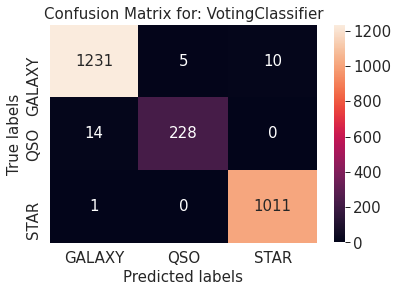

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.99      1.00      0.99      1012

    accuracy                           0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



By Acc:
VotingClassifier 0.9885333333333332


By Precision(avg=macro):
VotingClassifier 0.9855693099876338


By Recall(avg=macro):
VotingClassifier 0.97637403158787


By F1(avg=macro):
VotingClassifier 0.9808502512187219


VotingClassifier
{'QSO': 0.9699672056745895, 'STAR': 0.9961457137999914, 'GALAXY': 0.9879998771187416}


Data Set Type:  Robust Scaled
[0.98733333 0.98466667 0.99       0.99       0.99133333]
Accuracy: 0.989 (+/- 0.005)
VotingClassifier :
 [[1231    5   10]
 [  15  227    0]
 [   1    0 1011]]


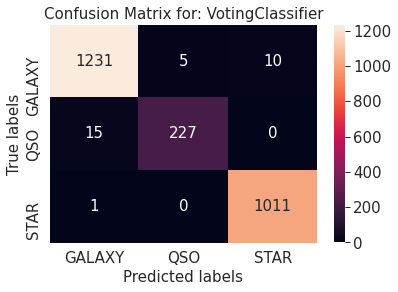

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.99      1.00      0.99      1012

    accuracy                           0.99      2500
   macro avg       0.99      0.97      0.98      2500
weighted avg       0.99      0.99      0.99      2500



By Acc:
VotingClassifier 0.9886666666666667


By Precision(avg=macro):
VotingClassifier 0.9852743875539623


By Recall(avg=macro):
VotingClassifier 0.9749966211195504


By F1(avg=macro):
VotingClassifier 0.9799867888715571


VotingClassifier
{'QSO': 0.9699672056745895, 'STAR': 0.9961457137999914, 'GALAXY': 0.9879998771187416}


VotingClassifier
{'QSO': 0.9679010899721101, 'STAR': 0.9961457137999914, 'GALAXY': 0.987601153035807}


Data Set Type:  MaxABS Scaled
[0.98666667 0.984      0.98866667 0.98933333 0.99133333]
Accuracy: 0.988 (+/- 0.005)
VotingClassifier :
 [[1230    5   11]
 [  14  228    0]
 [   1    0 

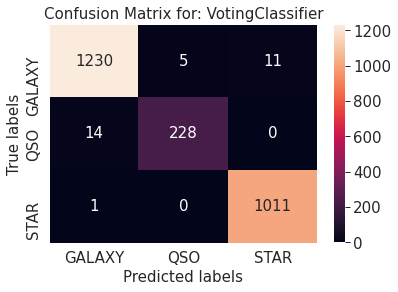

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.99      1.00      0.99      1012

    accuracy                           0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



By Acc:
VotingClassifier 0.9879999999999999


By Precision(avg=macro):
VotingClassifier 0.9852431234559194


By Recall(avg=macro):
VotingClassifier 0.9761065088484372


By F1(avg=macro):
VotingClassifier 0.9805518312335421


VotingClassifier
{'QSO': 0.9699672056745895, 'STAR': 0.9961457137999914, 'GALAXY': 0.9879998771187416}


VotingClassifier
{'QSO': 0.9679010899721101, 'STAR': 0.9961457137999914, 'GALAXY': 0.987601153035807}


VotingClassifier
{'QSO': 0.9699672056745895, 'STAR': 0.995809692294615, 'GALAXY': 0.9875985930095924}




In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.set_context("paper", rc={"font.size":15,
                          "axes.titlesize":15,
                         "axes.labelsize":15,
                          "xtick.labelsize":15,
                          "ytick.labelsize":15,
#                         "legend.fontsize":27
                            }) 
    results = helpers.learning_loop_for_sets(clfs, clf_names, class_names, data_sets)
    data = []
    for item in results:
        d = item.report_dict['macro avg']
        d['accuracy'] = item.scores.mean()
        d['classifier'] = item.classifier_name
        d['dataset_type'] = item.dataset_type
        data.append(d)

    df = pd.DataFrame(data=data)

In [9]:
len(results)

3

In [10]:
df.head(50)

,precision,recall,f1-score,support,accuracy,classifier,dataset_type
0,0.985569,0.976374,0.980850,2500,0.988533,VotingClassifier,Standard Scaled
1,0.985274,0.974997,0.979987,2500,0.988667,VotingClassifier,Robust Scaled
2,0.985243,0.976107,0.980552,2500,0.988000,VotingClassifier,MaxABS Scaled


In [11]:
#df.to_csv('results_no_opt.csv', encoding='utf-8', float_format='%.4f', index=False)